# Implementar o batch gradient descent - PyTorch

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import load_iris

### Carregando dados e normalizando

In [12]:
iris = load_iris()

ndata = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
tdata = torch.from_numpy(ndata)

x = tdata[:,0:1]
y = tdata[:,1:2]

a = [x.min(), y.min()]
a = min(a)
b = [x.max(), y.max()]
b = max(b)
x -= a
x /= b    # normalização
y -= a
y /= b

### Gradiente Descendente por Mini Lote (mini-batch)

In [13]:
def mini_batch_gradient_descent(X, y, w_init, b, lr, n_epochs):
    # quantidade de blocos
    M = int(y.size()[0]/b)
    # amostras restantes
    tail = y.size()[0]%b
    # hostórico de pesos
    w_history = torch.zeros((2,(M*n_epochs)+1))
    # peso inicial
    wT = w_init.t()
    # salva peso inicial no histórico
    w_history[:,0] = wT[:,0]
    
    for i in range(n_epochs):
        # pega o estado atual que será usado na 
        # próxima chamado do shuffle
        #rng_state = np.random.get_state()
        # embaralha X
        #np.random.shuffle(X)
        # seta o estado atual para o mesmo
        # usado no shuffle de X
        #np.random.set_state(rng_state)
        # embaralha y
        #np.random.shuffle(y)
        
        # inicial épocas
        for j in range(M):
            # elemento inicial do mini lote
            elemento_i = (j*b)
            # elemento final +1 do mini lote
            elemento_f = (j*b)+b
            # view do mini lote em X
            X_ = X[elemento_i:elemento_f]
            # view do mini lote em Y
            y_ = y[elemento_i:elemento_f]
            
            wT = wT - lr * (2.0 / b) * (X_.t()).mm(X_.mm(wT) - y_)
            w_history[:,j+(i*M)+1] = wT[:,0]

        # caso o número de blocos não seja exato,
        # tratamos o último lote separadamente
        if (tail > 0):
            # view do último mini lote em X
            X_ = X[-tail:]
            # view do último mini lote em Y
            y_ = y[-tail:]

            wT = wT - lr * (2.0 / tail) * (X_.t()).mm(X_.mm(wT) - y_)
            w_history[:,j+(i*M)+1] = wT[:,0]
            
    return w_history.t()

### Minimização via gradiente descendente por mini lote

In [14]:
# Parâmetros do gradiente descendente: número de iterações e taxa de aprendizagem
iterations = 100
lr = 0.1

n_samples = y.shape[0]

#Montagem da matriz X agora com os elementos 1 na primeira coluna
ones = torch.ones(n_samples,1)
ones = ones.type(torch.DoubleTensor)
X_bias = torch.cat((ones, x), 1)
w_init = torch.zeros(1,2).type(torch.DoubleTensor)

tam_lote = 1
w_history_1 = mini_batch_gradient_descent(X_bias, y, w_init, tam_lote, lr, iterations)

tam_lote = 9
w_history_T = mini_batch_gradient_descent(X_bias, y, w_init, tam_lote, lr, iterations)

tam_lote = 50
w_history_M = mini_batch_gradient_descent(X_bias, y, w_init, tam_lote, lr, iterations)

In [18]:
def xy_grid(h, w, s):
    x = torch.linspace(h, w, s)
    y = torch.linspace(h, w, s)
    grid = torch.stack([x.repeat(s), y.repeat(s,1).t().contiguous().view(-1)],1)
    return grid.t().type(torch.DoubleTensor)

In [21]:
def Jview(X_bias, y, w_history, w_opt, plt, ax):

    # parâmetros da função
    # quantos pesos gerar
    all = 1000
    # valor mínimo do grid
    min = -0.4
    # valor máximo do grid
    max = 1.0
    
    # Cálculo da matriz bidimensional de parâmetros
    X, Y = np.meshgrid(np.linspace(min, max, all), 
                         np.linspace(min, max, all))
    
    # Cálculo da matriz bidimensional de parâmetros
    wT = xy_grid(min, max, all)
        
    # calculo do custo
    J = compute_cost(X_bias, y, wT).view(all,all)
    J = J.numpy()
    
    # plotagem do espaço de parâmetros
    CS = plt.contourf(X, Y, J, 30, cmap=plt.cm.Blues_r)

    # plotagem do histórico dos pesos durante o treinamento
    w0 = w_history[0:,0].numpy()
    w1 = w_history[0:,1].numpy()
    plt.scatter(w0, w1, marker='o', c='r')

    w_opt = w_opt.numpy()
    
    # plotagem do da solução analítica
    plt.plot(w_opt[0], w_opt[1], 'wx')
    
    #plt.title('Visualização do treinamento de w na função de Custo J')
    
    # salva imagem
    #plt.savefig('fig_custo.png')

    #plt.show()

In [16]:
def compute_cost(X_b, y, wT):
    e = X_b.mm(wT) - y
    J = (e * e)
    J = torch.mean(J, 0)
    return J

w_opt = (torch.inverse((X_bias.t()).mm(X_bias)).mm(X_bias.t())).mm(y)

### Gerando a figura para correção automática

<a id='figura'></a>

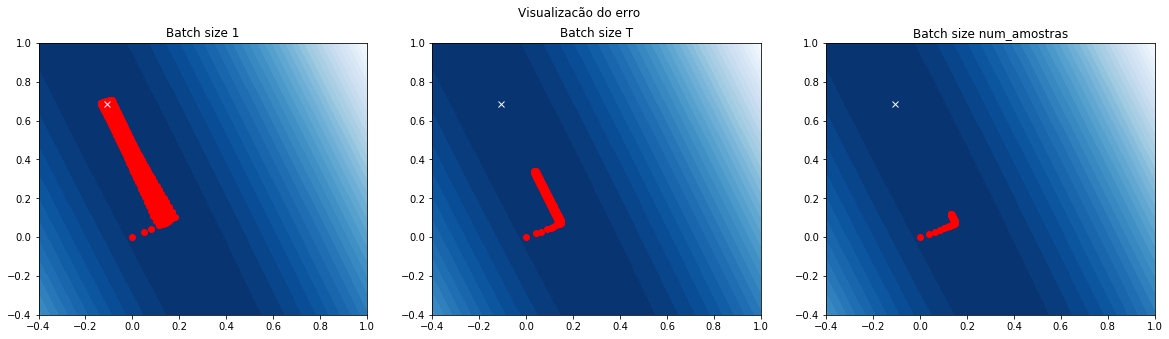

In [22]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Visualizacão do erro')

ax = fig.add_subplot(131)
plt.title("Batch size 1")
Jview(X_bias, y, w_history_1, w_opt, plt, ax)
#ax.plot(J_history_stochastic)

ay = fig.add_subplot(132)
plt.title("Batch size T")
Jview(X_bias, y, w_history_T, w_opt, plt, ay)
#ay.plot(J_history)

az = fig.add_subplot(133)
plt.title("Batch size num_amostras")
Jview(X_bias, y, w_history_M, w_opt, plt, az)
#az.plot(J_history)

plt.savefig('my_sgd_minibatch.png')